In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import *

* arrow
* udf (python vs scala)
* партиции и партиционирование
* кэширование
* оптимизации джоинов (broadcast)
* план выполнения (+ catalyst)
* чтение колоночных данных (parquet vs csv)

In [2]:
!hdfs dfsadmin -safemode leave

2023-11-28 14:53:43 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Safe mode is OFF


In [3]:
!hdfs dfs -rm -r ml-latest-small
!hdfs dfs -put ml-latest-small .

2023-11-28 14:53:44 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted ml-latest-small
2023-11-28 14:53:45 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Настройки- конфигурите ваше приложение правильно

* spark.driver.% (самое важное - memory)
* spark.executor.% (instances, memory, cores, memoryOverhea)
* spark.dinamicAllocation.% (initialExecutors, minExecutors, maxExecutors)
* spark.sql.shuffle.partitions - количество партиций в дочернем DataFrame после широкой трансформации
* spark.default.parallelizm - то же самое, только про RDD
* spark.memory.% - настройки связанные с управлением памятью (например, как распределить пространство на кэширование и выполнение)
* Компрессия и сериализация - опционально

In [2]:
conf = SparkConf()\
    .set("spark.executor.instances", "2")\
    .set("spark.executor.cores", "1")\
    .set("spark.executor.memory", "1g")

In [3]:
# conf = SparkConf()\
#     .set("spark.executor.instances", "3")

# Arrow - приходит на помощь pyspark-у

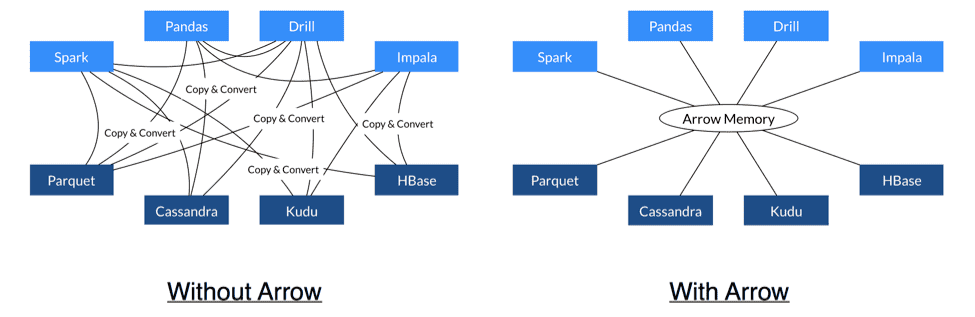

In [83]:
spark = SparkSession.builder.config(conf=conf).master(master="yarn").getOrCreate()

23/11/29 19:32:12 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [4]:
df = spark.range(int(1e6))\
    .withColumn("value", f.lit("bla bla bla"))\
    .cache()

In [5]:
df.show()

+---+-----------+
| id|      value|
+---+-----------+
|  0|bla bla bla|
|  1|bla bla bla|
|  2|bla bla bla|
|  3|bla bla bla|
|  4|bla bla bla|
|  5|bla bla bla|
|  6|bla bla bla|
|  7|bla bla bla|
|  8|bla bla bla|
|  9|bla bla bla|
| 10|bla bla bla|
| 11|bla bla bla|
| 12|bla bla bla|
| 13|bla bla bla|
| 14|bla bla bla|
| 15|bla bla bla|
| 16|bla bla bla|
| 17|bla bla bla|
| 18|bla bla bla|
| 19|bla bla bla|
+---+-----------+
only showing top 20 rows



In [6]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

In [7]:
%%time
pdf = df.toPandas()

CPU times: user 2.34 s, sys: 1.32 s, total: 3.66 s
Wall time: 6.71 s


In [8]:
pdf.head()

,id,value
0,0,bla bla bla
1,1,bla bla bla
2,2,bla bla bla
3,3,bla bla bla
4,4,bla bla bla


In [9]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [10]:
%%time
pdf = df.toPandas()

CPU times: user 144 ms, sys: 136 ms, total: 280 ms
Wall time: 1.53 s


In [11]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", 10)

In [12]:
%%time
pdf = df.toPandas()

CPU times: user 1.01 s, sys: 253 ms, total: 1.26 s
Wall time: 2.95 s


In [13]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", 100000)

In [14]:
%%time
pdf = df.toPandas()

CPU times: user 45.4 ms, sys: 93.9 ms, total: 139 ms
Wall time: 715 ms


## UDF - когда встреннных инструментов spark.sql уже недостаточно для выполнения ваших задач

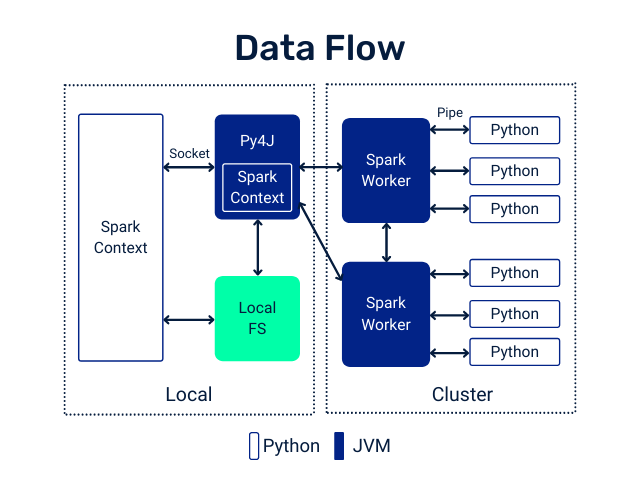

In [84]:
@f.pandas_udf(IntegerType())
def round_ratings(ratings):
    return round(ratings).astype(int)

In [85]:
ratings_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("rating", DoubleType()),
    StructField("timestamp", LongType()),
])

In [86]:
%%time
ratings_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(ratings_schema)\
    .load("ml-latest-small/ratings.csv")

CPU times: user 14.8 ms, sys: 340 µs, total: 15.1 ms
Wall time: 201 ms


In [87]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [88]:
ratings_with_round = ratings_df\
    .withColumn("ratings_round", round_ratings(f.col("rating")))

In [89]:
%%time
ratings_with_round.show()

+------+-------+------+---------+-------------+
|userId|movieId|rating|timestamp|ratings_round|
+------+-------+------+---------+-------------+
|     1|      1|   4.0|964982703|            4|
|     1|      3|   4.0|964981247|            4|
|     1|      6|   4.0|964982224|            4|
|     1|     47|   5.0|964983815|            5|
|     1|     50|   5.0|964982931|            5|
|     1|     70|   3.0|964982400|            3|
|     1|    101|   5.0|964980868|            5|
|     1|    110|   4.0|964982176|            4|
|     1|    151|   5.0|964984041|            5|
|     1|    157|   5.0|964984100|            5|
|     1|    163|   5.0|964983650|            5|
|     1|    216|   5.0|964981208|            5|
|     1|    223|   3.0|964980985|            3|
|     1|    231|   5.0|964981179|            5|
|     1|    235|   4.0|964980908|            4|
|     1|    260|   5.0|964981680|            5|
|     1|    296|   3.0|964982967|            3|
|     1|    316|   3.0|964982310|       

In [90]:
tags_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("tag", StringType()),
    StructField("timestamp", LongType()),
])

In [91]:
%%time
tags_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(tags_schema)\
    .load("ml-latest-small/tags.csv")

CPU times: user 1.59 ms, sys: 1.27 ms, total: 2.86 ms
Wall time: 66.3 ms


In [92]:
tags_df.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [93]:
@f.pandas_udf(IntegerType())
def len_tags(tags):
    return tags.apply(lambda x: len(x))

In [94]:
%%time
tags_df\
    .withColumn("tags_len", len_tags(f.col("tag")))\
    .collect()

CPU times: user 32.5 ms, sys: 2.53 ms, total: 35 ms
Wall time: 622 ms


[Row(userId=2, movieId=60756, tag='funny', timestamp=1445714994, tags_len=5),
 Row(userId=2, movieId=60756, tag='Highly quotable', timestamp=1445714996, tags_len=15),
 Row(userId=2, movieId=60756, tag='will ferrell', timestamp=1445714992, tags_len=12),
 Row(userId=2, movieId=89774, tag='Boxing story', timestamp=1445715207, tags_len=12),
 Row(userId=2, movieId=89774, tag='MMA', timestamp=1445715200, tags_len=3),
 Row(userId=2, movieId=89774, tag='Tom Hardy', timestamp=1445715205, tags_len=9),
 Row(userId=2, movieId=106782, tag='drugs', timestamp=1445715054, tags_len=5),
 Row(userId=2, movieId=106782, tag='Leonardo DiCaprio', timestamp=1445715051, tags_len=17),
 Row(userId=2, movieId=106782, tag='Martin Scorsese', timestamp=1445715056, tags_len=15),
 Row(userId=7, movieId=48516, tag='way too long', timestamp=1169687325, tags_len=12),
 Row(userId=18, movieId=431, tag='Al Pacino', timestamp=1462138765, tags_len=9),
 Row(userId=18, movieId=431, tag='gangster', timestamp=1462138749, tags_len

In [95]:
spark.stop()

# Партиции и партиционирование - когда правильное партиционирование данных может ускорить выполнение программы в разы

In [35]:
nums = list(range(10))
nums

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [36]:
spark = SparkSession.builder.appName("spark-partitons").config(conf=conf).master(master="yarn").getOrCreate()

23/11/29 19:07:22 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [29]:
conf.getAll()

[('spark.executor.instances', '2'),
 ('spark.executor.cores', '1'),
 ('spark.executor.memory', '1g')]

In [37]:
sc = spark.sparkContext

In [38]:
rdd = sc.parallelize(nums)
    
print("Number of partitions: ", rdd.getNumPartitions())
print("Default parallelism: ", sc.defaultParallelism)
print("Partitioner: ", rdd.partitioner)
print("Partitions structure: ", rdd.glom().collect())

Number of partitions:  2
Default parallelism:  2
Partitioner:  None


Partitions structure:  [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]


### Что произойдет, если партиций будет больше чем данных?

In [39]:
rdd = sc.parallelize(nums, 15)

print("Default parallelism: ", sc.defaultParallelism)
print("Number of partitions: ", rdd.getNumPartitions())
print("Partitioner: ", rdd.partitioner)
print("Partitions structure: ", rdd.glom().collect())

Default parallelism:  2
Number of partitions:  15
Partitioner:  None
Partitions structure:  [[], [0], [1], [], [2], [3], [], [4], [5], [], [6], [7], [], [8], [9]]


### Мы можем партиционировать данные как мы хотим:
* По нужным нам ключам
* На нужное количество партиций

In [40]:
transactions = [
    {"name": "Bob", "amount": 100, "country" : "UK"},
    {"name": "James", "amount": 5, "country" : "UK"},
    {"name": "Marek", "amount": 10, "country" : "Poland"},
    {"name": "Paul", "amount": 25, "country" : "Germany"},
    {"name": "Michael", "amount": 52, "country" : "Poland"},
    {"name": "Denis", "amount": 32, "country" : "Germany"}
    
]

In [41]:
def country_partitioner(country):
    mapping = {
        "UK": 0,
        "Poland": 1,
        "Germany": 2
    }
    return mapping.get(country, 999)

In [42]:
rdd = sc.parallelize(transactions) \
    .map(lambda x: (x["country"], x)) \
    .partitionBy(3, country_partitioner)

print("Number of partitions: ", rdd.getNumPartitions())
print("Partitioner: ", rdd.partitioner)
print("Partitions structure: ", rdd.glom().collect())

Number of partitions:  3
Partitioner:  <pyspark.rdd.Partitioner object at 0xffff4d2a4040>
Partitions structure:  [[('UK', {'name': 'Bob', 'amount': 100, 'country': 'UK'}), ('UK', {'name': 'James', 'amount': 5, 'country': 'UK'})], [('Poland', {'name': 'Michael', 'amount': 52, 'country': 'Poland'}), ('Poland', {'name': 'Marek', 'amount': 10, 'country': 'Poland'})], [('Germany', {'name': 'Paul', 'amount': 25, 'country': 'Germany'}), ('Germany', {'name': 'Denis', 'amount': 32, 'country': 'Germany'})]]


### В этих случаях мы говорим о так называемом "known partitioner", то есть о явно заданном партишинере

### Управление партиционированием можно делать и в dataframe в spark sql

In [43]:
df = spark.createDataFrame(transactions).repartition(4, "country")

print("Number of partitions: ", df.rdd.getNumPartitions())
print("Partitioner: ", df.rdd.partitioner)
print("Partitions structure: ", df.rdd.glom().collect())

Number of partitions:  4
Partitioner:  None
Partitions structure:  [[Row(amount=100, country='UK', name='Bob'), Row(amount=5, country='UK', name='James')], [], [Row(amount=25, country='Germany', name='Paul'), Row(amount=52, country='Poland', name='Michael'), Row(amount=32, country='Germany', name='Denis'), Row(amount=10, country='Poland', name='Marek')], []]


In [44]:
spark.stop()

### Именно правильное использование партишенеров сильно ускоряет выполнение программ

### known partitioner по умолчанию он не задается

In [45]:
keys = ['a'] * 1000 + ['b'] * 1000 + ['c'] * 1000 + ['d'] * 1000
values_left = [1] * 1000 + [2] * 1000 + [3] * 1000 + [4] * 1000
values_right = [5] * 1000 + [6] * 1000 + [7] * 1000 + [8] * 1000

In [48]:
keys

['a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a'

In [49]:
values_left

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [50]:
values_right

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,


In [46]:
conf_parallelizm = SparkConf()\
    .set("spark.default.parallelism", "10")

In [47]:
sc = SparkContext(master="yarn", appName="spark-parallelizm", conf=conf_parallelizm)

23/11/29 19:19:43 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [51]:
left_rdd = sc.parallelize(zip(keys, values_left)).repartition(2)

In [52]:
left_rdd.getNumPartitions()

2

In [53]:
left_rdd.partitioner

In [54]:
right_rdd = sc.parallelize(zip(keys, values_right)).repartition(2)

In [55]:
right_rdd.getNumPartitions()

2

In [56]:
right_rdd.partitioner

### После широких трансформаций количество партиций в дочернем рдд может отличаться от родительских

In [57]:
left_rdd.join(right_rdd).count()

4000000

In [58]:
left_rdd.join(right_rdd).getNumPartitions()

10

In [59]:
sc.stop()

### Если у двух RDD партишенеры явно заданы и они равны, то они называются копартиционированными

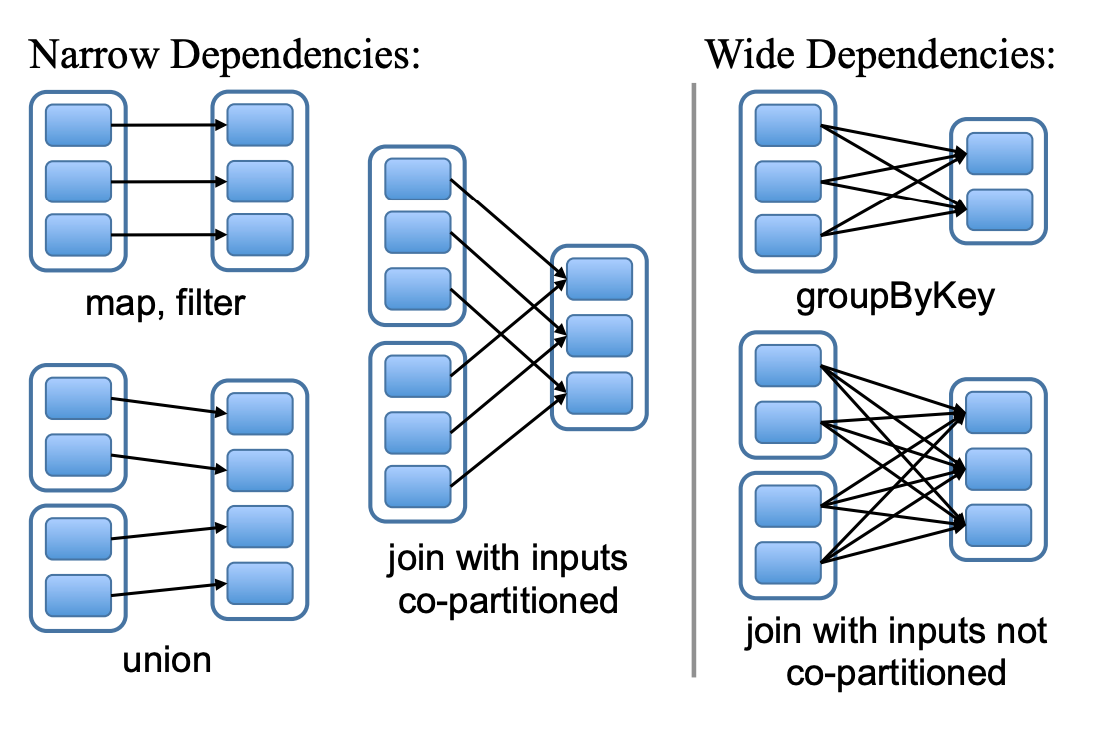

In [60]:
sc = SparkContext(master="yarn", appName="known-partitioner")

23/11/29 19:25:10 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [61]:
left_rdd = sc.parallelize(zip(keys, values_left))

In [62]:
right_rdd = sc.parallelize(zip(keys, values_right))

In [63]:
left_rdd_partitioned = left_rdd.partitionBy(4)

In [64]:
left_rdd_partitioned.partitioner

In [65]:
left_rdd_partitioned.take(5)

[('c', 3), ('c', 3), ('c', 3), ('c', 3), ('c', 3)]

In [66]:
right_rdd_partitioned = right_rdd.partitionBy(4)

In [67]:
right_rdd_partitioned.take(5)

[('c', 7), ('c', 7), ('c', 7), ('c', 7), ('c', 7)]

In [68]:
right_rdd_partitioned.partitioner

In [69]:
left_rdd_partitioned.partitioner == right_rdd_partitioned.partitioner

True

In [70]:
left_rdd_partitioned.join(left_rdd_partitioned).count()

4000000

In [66]:
left_rdd_partitioned.join(left_rdd_partitioned).getNumPartitions()

4

In [71]:
sc.stop()

In [72]:
conf_sql_copartitioned = SparkConf()\
    .set("spark.sql.shufle.partitions", "10")

In [73]:
spark = SparkSession.builder.appName("spark-sql-co-partitioning").config(conf=conf_sql_copartitioned).master(master="yarn").getOrCreate()

23/11/29 19:28:03 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [74]:
%%time
ratings_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(ratings_schema)\
    .load("ml-latest-small/ratings.csv")

CPU times: user 9.71 ms, sys: 2.18 ms, total: 11.9 ms
Wall time: 113 ms


In [75]:
%%time
tags_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(tags_schema)\
    .load("ml-latest-small/tags.csv")

CPU times: user 3 ms, sys: 2.48 ms, total: 5.48 ms
Wall time: 51.9 ms


In [76]:
ratings_df_repartitioned = ratings_df.repartition(4, "userId", "movieId")

In [78]:
tags_df_repartitioned = tags_df.repartition(4, "userId", "movieId")

In [79]:
joined_df_repartitioned = ratings_df_repartitioned\
    .join(tags_df_repartitioned, ["userId", "movieId"], "inner")\
    .repartition(4, "userId", "movieId")

In [80]:
joined_df_repartitioned.count()

3476

In [81]:
spark.stop()

# Персистентность и кэширование - когда преобразованные данные нужно использовать в приложении несколько раз

In [96]:
spark = SparkSession.builder.config(conf=conf).master(master="yarn").getOrCreate()

23/11/29 19:36:55 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [97]:
tags_df = spark.read.schema(tags_schema).csv("ml-latest-small/tags.csv", header=True)

In [98]:
tags_df.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [99]:
tags_df

DataFrame[userId: int, movieId: int, tag: string, timestamp: bigint]

In [100]:
%%time
ratings_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(ratings_schema)\
    .load("ml-latest-small/ratings.csv")

CPU times: user 1.33 ms, sys: 763 µs, total: 2.1 ms
Wall time: 26.2 ms


In [101]:
ratings_with_tags = ratings_df.alias("r").join(tags_df.alias("t"), on=["userId", "movieId"], how="left")

In [102]:
ratings_with_tags_cached = ratings_with_tags.cache()

In [103]:
ratings_with_tags_cached.show()

+------+-------+------+---------+----+---------+
|userId|movieId|rating|timestamp| tag|timestamp|
+------+-------+------+---------+----+---------+
|     1|      1|   4.0|964982703|NULL|     NULL|
|     1|      3|   4.0|964981247|NULL|     NULL|
|     1|      6|   4.0|964982224|NULL|     NULL|
|     1|     47|   5.0|964983815|NULL|     NULL|
|     1|     50|   5.0|964982931|NULL|     NULL|
|     1|     70|   3.0|964982400|NULL|     NULL|
|     1|    101|   5.0|964980868|NULL|     NULL|
|     1|    110|   4.0|964982176|NULL|     NULL|
|     1|    151|   5.0|964984041|NULL|     NULL|
|     1|    157|   5.0|964984100|NULL|     NULL|
|     1|    163|   5.0|964983650|NULL|     NULL|
|     1|    216|   5.0|964981208|NULL|     NULL|
|     1|    223|   3.0|964980985|NULL|     NULL|
|     1|    231|   5.0|964981179|NULL|     NULL|
|     1|    235|   4.0|964980908|NULL|     NULL|
|     1|    260|   5.0|964981680|NULL|     NULL|
|     1|    296|   3.0|964982967|NULL|     NULL|
|     1|    316|   3

In [20]:
ratings_with_tags_cached.count()

102677

In [104]:
from pyspark import StorageLevel

In [84]:
StorageLevel(False, True, False, False, 1)

In [105]:
ratings_with_tags_cached.rdd.getStorageLevel()

StorageLevel(False, False, False, False, 1)

In [106]:
ratings_with_tags_cached.is_cached

True

In [24]:
ratings_with_tags_rdd = ratings_with_tags_cached.rdd

In [25]:
ratings_with_tags_rdd_cached = ratings_with_tags_rdd.cache()

In [26]:
ratings_with_tags_rdd_cached.getStorageLevel()

StorageLevel(False, True, False, False, 1)

## А сколько мы можем закэшировать?

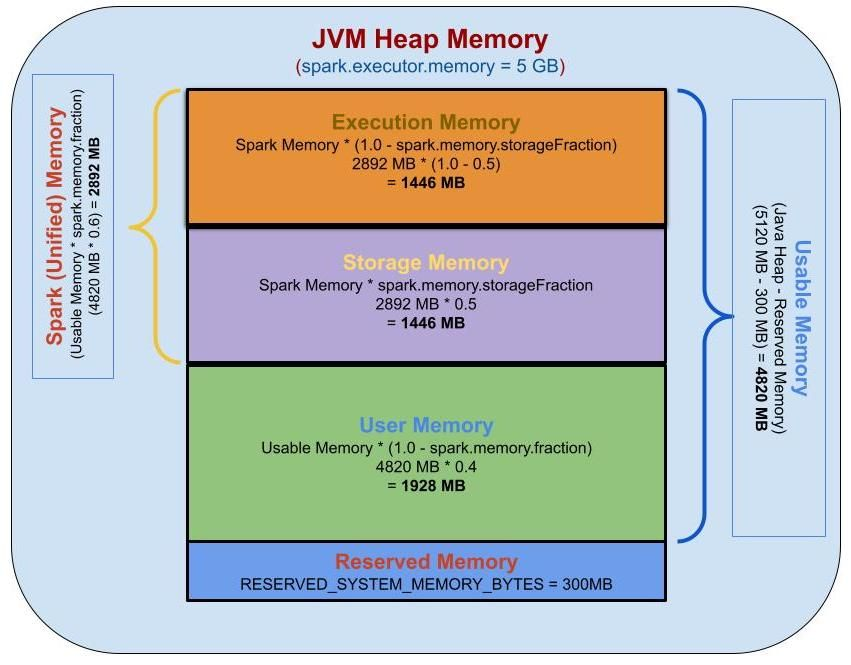

In [108]:
spark.stop()

In [107]:
1+1

2

## Catalyst - автоматически оптимизирует джобы над DataFrame-ами

* предварительный подсчет консант
* перемещение операции фильтрации на более ранние стадии (не путать со стейджами)
* может делать автоматический бродкаст
* селекция только нужных колонок для меньшего объема шафла (работает не со всеми типами данных - (с csv не работает, с паркетом работает)

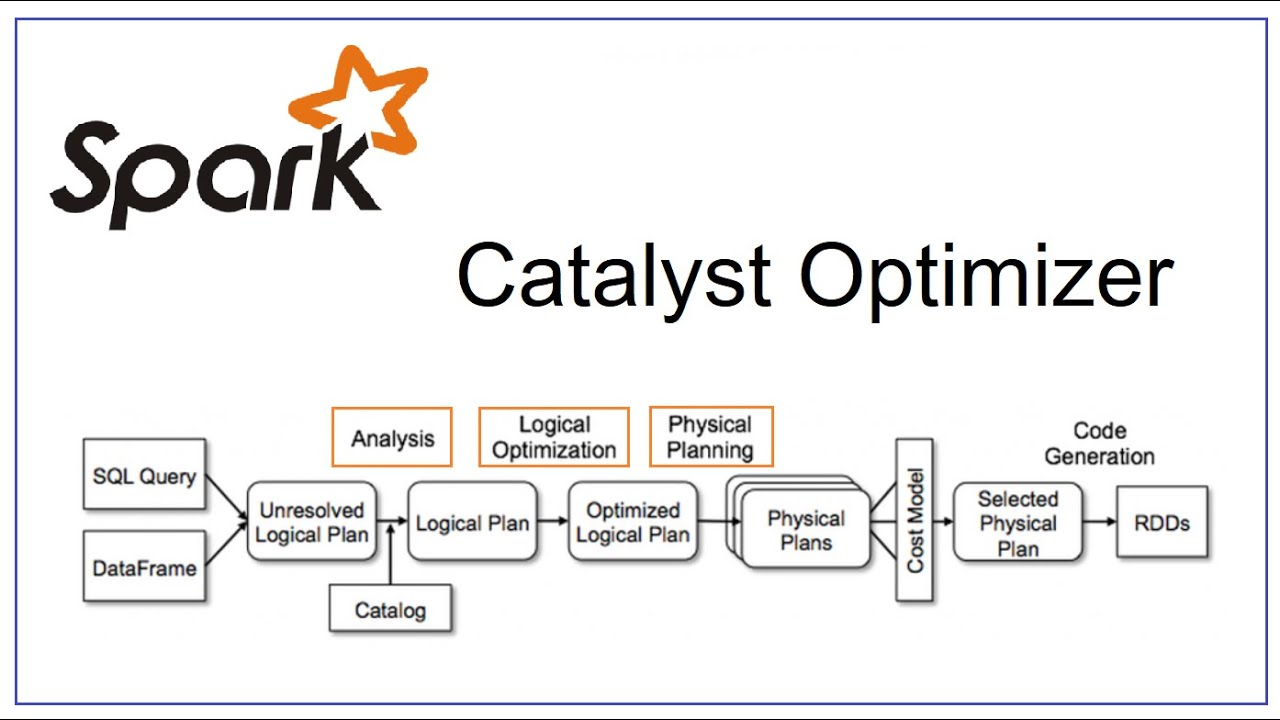

In [109]:
conf = SparkConf()\
    .set("spark.executor.instances", "2")\
    .set("spark.executor.cores", "1")\
    .set("spark.executor.memory", "1g")\
    .set("spark.sql.autoBroadcastJoinThreshold", "100500")

In [110]:
spark = SparkSession.builder.appName("spark-catalyst").config(conf=conf).master(master="yarn").getOrCreate()

23/11/29 19:55:44 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [111]:
%%time
ratings_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(ratings_schema)\
    .load("ml-latest-small/ratings.csv")

CPU times: user 13.8 ms, sys: 2.31 ms, total: 16.2 ms
Wall time: 153 ms


In [112]:
%%time
tags_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(tags_schema)\
    .load("ml-latest-small/tags.csv")

CPU times: user 3.78 ms, sys: 1.19 ms, total: 4.98 ms
Wall time: 53.1 ms


In [113]:
ratings_with_tags = ratings_df.alias("r").join(tags_df.alias("t"), on=["userId", "movieId"], how="left")

In [114]:
ratings_with_tags.explain(extended=True)

== Parsed Logical Plan ==
'Join UsingJoin(LeftOuter, [userId, movieId])
:- SubqueryAlias r
:  +- Relation [userId#806,movieId#807,rating#808,timestamp#809L] csv
+- SubqueryAlias t
   +- Relation [userId#814,movieId#815,tag#816,timestamp#817L] csv

== Analyzed Logical Plan ==
userId: int, movieId: int, rating: double, timestamp: bigint, tag: string, timestamp: bigint
Project [userId#806, movieId#807, rating#808, timestamp#809L, tag#816, timestamp#817L]
+- Join LeftOuter, ((userId#806 = userId#814) AND (movieId#807 = movieId#815))
   :- SubqueryAlias r
   :  +- Relation [userId#806,movieId#807,rating#808,timestamp#809L] csv
   +- SubqueryAlias t
      +- Relation [userId#814,movieId#815,tag#816,timestamp#817L] csv

== Optimized Logical Plan ==
Project [userId#806, movieId#807, rating#808, timestamp#809L, tag#816, timestamp#817L]
+- Join LeftOuter, ((userId#806 = userId#814) AND (movieId#807 = movieId#815))
   :- Relation [userId#806,movieId#807,rating#808,timestamp#809L] csv
   +- Filter

## broadcast - must have для джоина маленьких таблиц

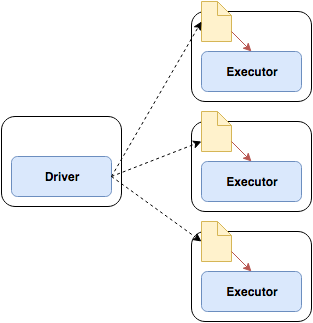

In [115]:
ratings_with_tags_broadcast = ratings_df.alias("r").join(f.broadcast(tags_df.alias("t")), on=["userId", "movieId"], how="left")

In [116]:
ratings_with_tags_broadcast.explain(extended=True)

== Parsed Logical Plan ==
'Join UsingJoin(LeftOuter, [userId, movieId])
:- SubqueryAlias r
:  +- Relation [userId#806,movieId#807,rating#808,timestamp#809L] csv
+- ResolvedHint (strategy=broadcast)
   +- SubqueryAlias t
      +- Relation [userId#814,movieId#815,tag#816,timestamp#817L] csv

== Analyzed Logical Plan ==
userId: int, movieId: int, rating: double, timestamp: bigint, tag: string, timestamp: bigint
Project [userId#806, movieId#807, rating#808, timestamp#809L, tag#816, timestamp#817L]
+- Join LeftOuter, ((userId#806 = userId#814) AND (movieId#807 = movieId#815))
   :- SubqueryAlias r
   :  +- Relation [userId#806,movieId#807,rating#808,timestamp#809L] csv
   +- ResolvedHint (strategy=broadcast)
      +- SubqueryAlias t
         +- Relation [userId#814,movieId#815,tag#816,timestamp#817L] csv

== Optimized Logical Plan ==
Project [userId#806, movieId#807, rating#808, timestamp#809L, tag#816, timestamp#817L]
+- Join LeftOuter, ((userId#806 = userId#814) AND (movieId#807 = movieId

In [117]:
%%time
ratings_with_tags.collect()

CPU times: user 1.16 s, sys: 32.5 ms, total: 1.2 s
Wall time: 6.55 s


[Row(userId=1, movieId=1, rating=4.0, timestamp=964982703, tag=None, timestamp=None),
 Row(userId=1, movieId=3, rating=4.0, timestamp=964981247, tag=None, timestamp=None),
 Row(userId=1, movieId=6, rating=4.0, timestamp=964982224, tag=None, timestamp=None),
 Row(userId=1, movieId=47, rating=5.0, timestamp=964983815, tag=None, timestamp=None),
 Row(userId=1, movieId=50, rating=5.0, timestamp=964982931, tag=None, timestamp=None),
 Row(userId=1, movieId=70, rating=3.0, timestamp=964982400, tag=None, timestamp=None),
 Row(userId=1, movieId=101, rating=5.0, timestamp=964980868, tag=None, timestamp=None),
 Row(userId=1, movieId=110, rating=4.0, timestamp=964982176, tag=None, timestamp=None),
 Row(userId=1, movieId=151, rating=5.0, timestamp=964984041, tag=None, timestamp=None),
 Row(userId=1, movieId=157, rating=5.0, timestamp=964984100, tag=None, timestamp=None),
 Row(userId=1, movieId=163, rating=5.0, timestamp=964983650, tag=None, timestamp=None),
 Row(userId=1, movieId=216, rating=5.0, t

In [118]:
%%time
ratings_with_tags_broadcast.collect()

CPU times: user 720 ms, sys: 0 ns, total: 720 ms
Wall time: 1.81 s


[Row(userId=1, movieId=1, rating=4.0, timestamp=964982703, tag=None, timestamp=None),
 Row(userId=1, movieId=3, rating=4.0, timestamp=964981247, tag=None, timestamp=None),
 Row(userId=1, movieId=6, rating=4.0, timestamp=964982224, tag=None, timestamp=None),
 Row(userId=1, movieId=47, rating=5.0, timestamp=964983815, tag=None, timestamp=None),
 Row(userId=1, movieId=50, rating=5.0, timestamp=964982931, tag=None, timestamp=None),
 Row(userId=1, movieId=70, rating=3.0, timestamp=964982400, tag=None, timestamp=None),
 Row(userId=1, movieId=101, rating=5.0, timestamp=964980868, tag=None, timestamp=None),
 Row(userId=1, movieId=110, rating=4.0, timestamp=964982176, tag=None, timestamp=None),
 Row(userId=1, movieId=151, rating=5.0, timestamp=964984041, tag=None, timestamp=None),
 Row(userId=1, movieId=157, rating=5.0, timestamp=964984100, tag=None, timestamp=None),
 Row(userId=1, movieId=163, rating=5.0, timestamp=964983650, tag=None, timestamp=None),
 Row(userId=1, movieId=216, rating=5.0, t

### Parquet vs csv - вот почему parquet самый популярный формат хранения данных для spark

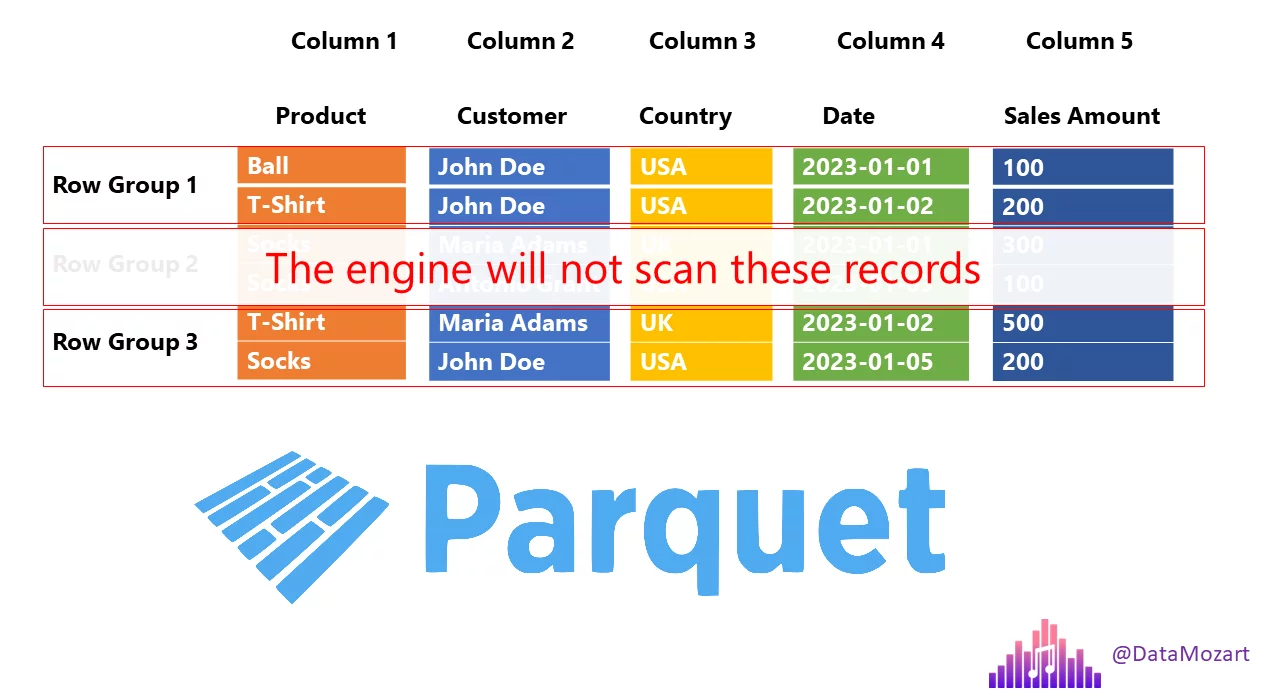

In [119]:
ratings_df\
    .write\
    .mode("overwrite")\
    .parquet("ml-latest-small/ratings")

In [120]:
tags_df\
    .write\
    .mode("overwrite")\
    .parquet("ml-latest-small/tags")

In [121]:
%%time
ratings_parquet = spark\
    .read\
    .format("parquet")\
    .option("header", "True")\
    .load("ml-latest-small/ratings")

CPU times: user 6.68 ms, sys: 1.89 ms, total: 8.56 ms
Wall time: 706 ms


In [122]:
ratings_parquet

DataFrame[userId: int, movieId: int, rating: double, timestamp: bigint]

In [123]:
ratings_parquet.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [124]:
%%time
tags_parquet = spark\
    .read\
    .format("parquet")\
    .option("header", "True")\
    .load("ml-latest-small/tags")

CPU times: user 4.96 ms, sys: 1.61 ms, total: 6.57 ms
Wall time: 183 ms


In [125]:
tags_parquet

DataFrame[userId: int, movieId: int, tag: string, timestamp: bigint]

In [126]:
tags_parquet.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [57]:
ratings_with_tags_parquet = ratings_parquet.join(f.broadcast(tags_parquet), on=["userId", "movieId"], how="inner")

In [58]:
users_count_parquet = ratings_with_tags_parquet \
    .groupBy("userId") \
    .count()

In [59]:
users_count_parquet.explain(extended=True)

== Parsed Logical Plan ==
'Aggregate ['userId], ['userId, count(1) AS count#748L]
+- Project [userId#683, movieId#684, rating#685, timestamp#686L, tag#711, timestamp#712L]
   +- Join Inner, ((userId#683 = userId#709) AND (movieId#684 = movieId#710))
      :- Relation [userId#683,movieId#684,rating#685,timestamp#686L] parquet
      +- ResolvedHint (strategy=broadcast)
         +- Relation [userId#709,movieId#710,tag#711,timestamp#712L] parquet

== Analyzed Logical Plan ==
userId: int, count: bigint
Aggregate [userId#683], [userId#683, count(1) AS count#748L]
+- Project [userId#683, movieId#684, rating#685, timestamp#686L, tag#711, timestamp#712L]
   +- Join Inner, ((userId#683 = userId#709) AND (movieId#684 = movieId#710))
      :- Relation [userId#683,movieId#684,rating#685,timestamp#686L] parquet
      +- ResolvedHint (strategy=broadcast)
         +- Relation [userId#709,movieId#710,tag#711,timestamp#712L] parquet

== Optimized Logical Plan ==
Aggregate [userId#683], [userId#683, coun

# вложенность полей

In [64]:
users_count_parquet = ratings_with_tags_parquet \
    .groupBy("userId") \
    .count()

In [65]:
users_count_parquet.explain(extended=True)

== Parsed Logical Plan ==
'Aggregate ['userId], ['userId, count(1) AS count#784L]
+- Project [userId#683, movieId#684, rating#685, timestamp#686L, tag#711, timestamp#712L]
   +- Join Inner, ((userId#683 = userId#709) AND (movieId#684 = movieId#710))
      :- Relation [userId#683,movieId#684,rating#685,timestamp#686L] parquet
      +- ResolvedHint (strategy=broadcast)
         +- Relation [userId#709,movieId#710,tag#711,timestamp#712L] parquet

== Analyzed Logical Plan ==
userId: int, count: bigint
Aggregate [userId#683], [userId#683, count(1) AS count#784L]
+- Project [userId#683, movieId#684, rating#685, timestamp#686L, tag#711, timestamp#712L]
   +- Join Inner, ((userId#683 = userId#709) AND (movieId#684 = movieId#710))
      :- Relation [userId#683,movieId#684,rating#685,timestamp#686L] parquet
      +- ResolvedHint (strategy=broadcast)
         +- Relation [userId#709,movieId#710,tag#711,timestamp#712L] parquet

== Optimized Logical Plan ==
Aggregate [userId#683], [userId#683, coun

In [76]:
users_count = ratings_with_tags \
    .groupBy("userId") \
    .count()

In [67]:
users_count.explain(extended=True)

== Parsed Logical Plan ==
'Aggregate ['userId], ['userId, count(1) AS count#796L]
+- Project [userId#621, movieId#622, rating#623, timestamp#624L, tag#631, timestamp#632L]
   +- Join LeftOuter, ((userId#621 = userId#629) AND (movieId#622 = movieId#630))
      :- SubqueryAlias r
      :  +- Relation [userId#621,movieId#622,rating#623,timestamp#624L] csv
      +- SubqueryAlias t
         +- Relation [userId#629,movieId#630,tag#631,timestamp#632L] csv

== Analyzed Logical Plan ==
userId: int, count: bigint
Aggregate [userId#621], [userId#621, count(1) AS count#796L]
+- Project [userId#621, movieId#622, rating#623, timestamp#624L, tag#631, timestamp#632L]
   +- Join LeftOuter, ((userId#621 = userId#629) AND (movieId#622 = movieId#630))
      :- SubqueryAlias r
      :  +- Relation [userId#621,movieId#622,rating#623,timestamp#624L] csv
      +- SubqueryAlias t
         +- Relation [userId#629,movieId#630,tag#631,timestamp#632L] csv

== Optimized Logical Plan ==
Aggregate [userId#621], [user

In [68]:
users_count = ratings_df \
    .groupBy("userId") \
    .count()

In [69]:
users_count.explain(extended=True)

== Parsed Logical Plan ==
'Aggregate ['userId], ['userId, count(1) AS count#806L]
+- Relation [userId#621,movieId#622,rating#623,timestamp#624L] csv

== Analyzed Logical Plan ==
userId: int, count: bigint
Aggregate [userId#621], [userId#621, count(1) AS count#806L]
+- Relation [userId#621,movieId#622,rating#623,timestamp#624L] csv

== Optimized Logical Plan ==
Aggregate [userId#621], [userId#621, count(1) AS count#806L]
+- Project [userId#621]
   +- Relation [userId#621,movieId#622,rating#623,timestamp#624L] csv

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[userId#621], functions=[count(1)], output=[userId#621, count#806L])
   +- Exchange hashpartitioning(userId#621, 200), ENSURE_REQUIREMENTS, [plan_id=602]
      +- HashAggregate(keys=[userId#621], functions=[partial_count(1)], output=[userId#621, count#810L])
         +- FileScan csv [userId#621] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://namenode/user/ro

In [70]:
users_count_parquet = ratings_parquet \
    .groupBy("userId") \
    .count()

In [71]:
users_count_parquet.explain(extended=True)

== Parsed Logical Plan ==
'Aggregate ['userId], ['userId, count(1) AS count#816L]
+- Relation [userId#683,movieId#684,rating#685,timestamp#686L] parquet

== Analyzed Logical Plan ==
userId: int, count: bigint
Aggregate [userId#683], [userId#683, count(1) AS count#816L]
+- Relation [userId#683,movieId#684,rating#685,timestamp#686L] parquet

== Optimized Logical Plan ==
Aggregate [userId#683], [userId#683, count(1) AS count#816L]
+- Project [userId#683]
   +- Relation [userId#683,movieId#684,rating#685,timestamp#686L] parquet

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[userId#683], functions=[count(1)], output=[userId#683, count#816L])
   +- Exchange hashpartitioning(userId#683, 200), ENSURE_REQUIREMENTS, [plan_id=615]
      +- HashAggregate(keys=[userId#683], functions=[partial_count(1)], output=[userId#683, count#820L])
         +- FileScan parquet [userId#683] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs

In [72]:
%%time
users_count_parquet.collect()

CPU times: user 15.2 ms, sys: 6.29 ms, total: 21.5 ms
Wall time: 1.17 s


[Row(userId=148, count=48),
 Row(userId=463, count=33),
 Row(userId=471, count=28),
 Row(userId=496, count=29),
 Row(userId=243, count=36),
 Row(userId=392, count=25),
 Row(userId=540, count=42),
 Row(userId=31, count=50),
 Row(userId=516, count=26),
 Row(userId=85, count=34),
 Row(userId=137, count=141),
 Row(userId=251, count=23),
 Row(userId=451, count=34),
 Row(userId=580, count=436),
 Row(userId=65, count=34),
 Row(userId=458, count=59),
 Row(userId=53, count=20),
 Row(userId=255, count=44),
 Row(userId=481, count=31),
 Row(userId=588, count=56),
 Row(userId=133, count=35),
 Row(userId=296, count=27),
 Row(userId=472, count=29),
 Row(userId=78, count=61),
 Row(userId=322, count=107),
 Row(userId=513, count=32),
 Row(userId=321, count=56),
 Row(userId=362, count=109),
 Row(userId=375, count=33),
 Row(userId=593, count=103),
 Row(userId=597, count=443),
 Row(userId=108, count=76),
 Row(userId=155, count=46),
 Row(userId=34, count=86),
 Row(userId=193, count=35),
 Row(userId=211, cou

In [77]:
%%time
users_count.collect()

CPU times: user 6.5 ms, sys: 3.64 ms, total: 10.1 ms
Wall time: 692 ms


[Row(userId=148, count=48),
 Row(userId=463, count=33),
 Row(userId=471, count=28),
 Row(userId=496, count=29),
 Row(userId=243, count=36),
 Row(userId=392, count=25),
 Row(userId=540, count=42),
 Row(userId=31, count=50),
 Row(userId=516, count=26),
 Row(userId=85, count=34),
 Row(userId=137, count=141),
 Row(userId=251, count=23),
 Row(userId=451, count=34),
 Row(userId=580, count=436),
 Row(userId=65, count=34),
 Row(userId=458, count=59),
 Row(userId=53, count=20),
 Row(userId=255, count=44),
 Row(userId=481, count=31),
 Row(userId=588, count=56),
 Row(userId=133, count=35),
 Row(userId=296, count=27),
 Row(userId=472, count=29),
 Row(userId=78, count=61),
 Row(userId=322, count=107),
 Row(userId=513, count=33),
 Row(userId=321, count=56),
 Row(userId=362, count=109),
 Row(userId=375, count=33),
 Row(userId=593, count=103),
 Row(userId=597, count=443),
 Row(userId=108, count=76),
 Row(userId=155, count=46),
 Row(userId=34, count=86),
 Row(userId=193, count=48),
 Row(userId=211, cou

In [127]:
spark.stop()